# Day 53：对抗生成网络 (GAN) 实战


---

## 一、GAN 核心思想

### 1.1 什么是 GAN？

**GAN（Generative Adversarial Network，对抗生成网络）** 是一种强大的生成模型，由 Ian Goodfellow 于 2014 年提出。它的核心思想是通过两个神经网络的**对抗博弈**来生成逼真的数据。

- **生成器 (Generator)**：负责生成假数据，目标是让判别器无法区分真假
- **判别器 (Discriminator)**：负责区分真实数据和生成数据，目标是准确识别假数据

> **通俗类比**：假设生成器是一个造假币专家，判别器是一个验钞员。两者不断博弈：造假者越来越会造假币，验钞员则越来越会验钞。最终造假者能造出以假乱真的假币。

### 1.2 GAN 的工作原理

整个训练过程可以概括为以下步骤：

1. **初始化阶段**：随机初始化生成器和判别器的网络参数

2. **判别器训练**
   - 给判别器看真实数据，标签为 1（真）
   - 给判别器看生成器产生的假数据，标签为 0（假）
   - 根据分类结果更新判别器参数

3. **生成器训练**
   - 生成器接收随机噪声，生成假数据
   - 将假数据送给判别器判断
   - 如果判别器识破为假，生成器需要更新参数

4. **迭代优化**：交替训练判别器和生成器，直到生成器能生成足够逼真的数据

### 1.3 损失函数设计

GAN 的损失函数设计是理解其训练机制的关键：

| 网络 | 损失来源 | 优化目标 |
| --- | --- | --- |
| 判别器 | 真实数据判真 + 假数据判假 | 最大化分类准确率 |
| 生成器 | 假数据被判为真的程度 | 最大化欺骗判别器的概率 |

判别器损失同时包含真实数据判真和生成数据判假两部分，而生成器损失仅针对生成数据被判别为真的目标。实际训练中，两者的优化是交替进行的（先训判别器，再训生成器）。

### 1.4 应用场景

GAN 在处理**数据不平衡问题**时非常有用：

- **结构化数据**：可以使用 SMOTE 等过采样方法
- **图像数据**：可以使用数据增强、设置类别权重等方法
- **GAN 方法**：直接生成少数类样本，解决类别不平衡问题

---

## 二、环境配置与数据准备

In [1]:
# =====================================
# 1. 导入必要的库
# =====================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# =====================================
# 2. 检查 GPU 可用性
# =====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [2]:
# =====================================
# 3. 定义超参数
# =====================================
LATENT_DIM = 10     # 潜在空间维度（噪声向量的维度）
EPOCHS = 10000      # 训练轮数（GAN 通常需要较长时间训练）
BATCH_SIZE = 32     # 批次大小
LR = 0.0002         # 学习率
BETA1 = 0.5         # Adam 优化器的 beta1 参数

print(f"超参数配置:")
print(f"  - 潜在空间维度: {LATENT_DIM}")
print(f"  - 训练轮数: {EPOCHS}")
print(f"  - 批次大小: {BATCH_SIZE}")
print(f"  - 学习率: {LR}")

超参数配置:
  - 潜在空间维度: 10
  - 训练轮数: 10000
  - 批次大小: 32
  - 学习率: 0.0002


In [3]:
# =====================================
# 4. 加载并预处理数据
# =====================================

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data      # 特征数据
y = iris.target    # 标签

# 只选择 Setosa 类别（类别 0）进行训练
# 这里模拟了一个场景：某类样本数量不足，使用 GAN 生成更多样本
X_class0 = X[y == 0]

# 数据缩放到 [-1, 1] 范围
# 原因：生成器的输出层使用 Tanh 激活函数，输出范围是 [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_class0)

# 转换为 PyTorch Tensor 并创建 DataLoader
real_data_tensor = torch.from_numpy(X_scaled).float()
dataset = TensorDataset(real_data_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"成功加载并预处理数据")
print(f"  - 训练样本数量: {len(X_scaled)}")
print(f"  - 数据特征维度: {X_scaled.shape[1]}")

成功加载并预处理数据
  - 训练样本数量: 50
  - 数据特征维度: 4


---

## 三、生成器 (Generator)

In [4]:
# =====================================
# 5. 定义生成器网络
# =====================================

class Generator(nn.Module):
    """生成器网络：将随机噪声转换为与真实数据相似的数据"""
    
    def __init__(self):
        super(Generator, self).__init__()
        
        # 使用 Sequential 容器定义网络结构
        self.model = nn.Sequential(
            # 输入层：接收潜在空间的噪声向量
            nn.Linear(LATENT_DIM, 16),  # LATENT_DIM -> 16
            nn.ReLU(),                   # 激活函数
            
            # 隐藏层
            nn.Linear(16, 32),           # 16 -> 32
            nn.ReLU(),
            
            # 输出层：维度与目标数据对齐（鸢尾花有 4 个特征）
            nn.Linear(32, 4),            # 32 -> 4
            nn.Tanh()                    # 输出范围 [-1, 1]
        )

    def forward(self, x):
        """前向传播：输入噪声，输出生成的数据"""
        return self.model(x)

### 3.1 nn.Sequential 容器详解

nn.Sequential 是 PyTorch 提供的一个**按顺序执行**的容器。它的优势是：

- **简化代码**：将多个层按顺序放入容器中，自动连接
- **简化前向传播**：只需调用 self.model(x) 即可

除了 nn.Sequential 这种按顺序运算的容器，还有一些其他的容器，比如 nn.ModuleList 对于消融实验会起到简化代码的作用。

### 3.2 何时使用手动 forward() 方法

当网络结构**无法用线性顺序表示**时，必须手动编写 forward() 方法：

| 场景 | 说明 |
| --- | --- |
| 残差连接 (ResNet) | 输出需要与输入相加 |
| 多分支结构 (Inception) | 多条路径并行执行后合并 |
| 条件判断 | 根据输入条件选择不同的处理路径 |

> **总结**：线性堆叠结构用 Sequential，复杂分支结构手动编写 forward()

---

## 四、判别器 (Discriminator)

In [5]:
# =====================================
# 6. 定义判别器网络
# =====================================

class Discriminator(nn.Module):
    """判别器网络：判断输入数据是真实数据还是生成数据"""
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # 输入层：接收数据样本（4 个特征）
            nn.Linear(4, 32),
            nn.LeakyReLU(0.2),  # 使用 LeakyReLU，负斜率为 0.2
            
            # 隐藏层
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            
            # 输出层：输出 1 个值（真/假的概率）
            nn.Linear(16, 1),
            nn.Sigmoid()         # 输出 0~1 的概率值
        )

    def forward(self, x):
        """前向传播：输入数据，输出真假概率"""
        return self.model(x)

### 4.1 激活函数与损失函数的对应关系

**二分类问题**常见的两种输出方式：

| 输出方式 | 激活函数 | 损失函数 | 说明 |
| --- | --- | --- | --- |
| 单输出（推荐） | Sigmoid | BCE（二元交叉熵） | 输出 1 个概率值 |
| 双输出 | Softmax | CrossEntropy | 输出 2 个类别概率 |

> 对于 GAN 的判别器，通常采用**单输出 + Sigmoid + BCE**的方式。

### 4.2 LeakyReLU 激活函数

**为什么 GAN 的判别器常用 LeakyReLU？**

| 激活函数 | 公式 | 优点 | 缺点 |
| --- | --- | --- | --- |
| ReLU | f(x) = max(0, x) | 计算简单，缓解梯度消失 | 神经元死亡问题 |
| LeakyReLU | f(x) = max(0.01x, x) | 避免神经元死亡 | 需要调整负斜率参数 |

**神经元死亡问题**：当 ReLU 的输入长期为负时，梯度为 0，该神经元永远不会被激活，参数无法更新。

**LeakyReLU 解决方案**：对负数输入保留一个小的梯度（如 0.01 或 0.2），确保梯度始终存在。

> 许多 GAN 变体（DCGAN、WGAN）默认使用 LeakyReLU，实验证明能提高收敛速度和生成质量。

---

## 五、模型实例化与训练配置

In [6]:
# =====================================
# 7. 实例化模型
# =====================================
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("=" * 50)
print("生成器结构:")
print("=" * 50)
print(generator)

print("\n" + "=" * 50)
print("判别器结构:")
print("=" * 50)
print(discriminator)

生成器结构:
Generator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
    (5): Tanh()
  )
)

判别器结构:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [7]:
# =====================================
# 8. 定义损失函数和优化器
# =====================================

# 二元交叉熵损失函数
criterion = nn.BCELoss()

# 分别为生成器和判别器设置独立的优化器
# 注意：GAN 中两个网络需要分开训练，因此需要两个优化器
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

print("损失函数: BCELoss（二元交叉熵）")
print("优化器: Adam")
print(f"  - 学习率: {LR}")
print(f"  - Betas: ({BETA1}, 0.999)")

损失函数: BCELoss（二元交叉熵）
优化器: Adam
  - 学习率: 0.0002
  - Betas: (0.5, 0.999)


---

## 六、训练循环

In [8]:
# =====================================
# 9. 训练循环
# =====================================

print("\n" + "=" * 50)
print("开始训练 GAN")
print("=" * 50)

for epoch in range(EPOCHS):
    for i, (real_data,) in enumerate(dataloader):
        # ---------------------------------
        # 准备数据和标签
        # ---------------------------------
        real_data = real_data.to(device)
        current_batch_size = real_data.size(0)

        # 创建真实和虚假的标签
        # 真实数据标签为 1，假数据标签为 0
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # =================================
        # 第一步：训练判别器
        # =================================
        d_optimizer.zero_grad()  # 梯度清零

        # (1) 用真实数据训练判别器
        real_output = discriminator(real_data)
        d_loss_real = criterion(real_output, real_labels)
        
        # (2) 用生成的假数据训练判别器
        noise = torch.randn(current_batch_size, LATENT_DIM).to(device)
        # 使用 .detach() 阻止梯度流回生成器
        # 原因：在训练判别器时，不应该更新生成器的参数
        fake_data = generator(noise).detach()
        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        
        # (3) 计算总损失并反向传播
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # =================================
        # 第二步：训练生成器
        # =================================
        g_optimizer.zero_grad()  # 梯度清零

        # 生成新的假数据，并尝试欺骗判别器
        noise = torch.randn(current_batch_size, LATENT_DIM).to(device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        
        # 生成器的损失：目标是让判别器将假数据误判为真（标签为 1）
        g_loss = criterion(fake_output, real_labels)
        
        # 反向传播并更新生成器参数
        g_loss.backward()
        g_optimizer.step()

    # ---------------------------------
    # 每 1000 个 epoch 打印训练状态
    # ---------------------------------
    if (epoch + 1) % 1000 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], "
            f"D_Loss: {d_loss.item():.4f}, "
            f"G_Loss: {g_loss.item():.4f}"
        )

print("\n" + "=" * 50)
print("训练完成！")
print("=" * 50)


开始训练 GAN
Epoch [1000/10000], D_Loss: 1.5033, G_Loss: 0.5938
Epoch [2000/10000], D_Loss: 1.4144, G_Loss: 0.6407
Epoch [3000/10000], D_Loss: 1.3802, G_Loss: 0.6965
Epoch [4000/10000], D_Loss: 1.3711, G_Loss: 0.7036
Epoch [5000/10000], D_Loss: 1.3513, G_Loss: 0.7462
Epoch [6000/10000], D_Loss: 1.3389, G_Loss: 0.7139
Epoch [7000/10000], D_Loss: 1.3091, G_Loss: 0.7179
Epoch [8000/10000], D_Loss: 1.3107, G_Loss: 0.7122
Epoch [9000/10000], D_Loss: 1.3499, G_Loss: 0.7069
Epoch [10000/10000], D_Loss: 1.2848, G_Loss: 0.7199

训练完成！


---

## 七、结果生成与可视化

In [9]:
# =====================================
# 10. 生成新数据并可视化
# =====================================

print("\n" + "=" * 50)
print("生成并可视化结果")
print("=" * 50)

# 将生成器设为评估模式
generator.eval()

# 使用 torch.no_grad() 关闭梯度计算，节省内存
with torch.no_grad():
    num_new_samples = 50  # 生成 50 个新样本
    noise = torch.randn(num_new_samples, LATENT_DIM).to(device)
    generated_data_scaled = generator(noise)

# 将数据从 GPU 移到 CPU，并转换为 numpy 数组
generated_data_scaled_np = generated_data_scaled.cpu().numpy()

# 逆向转换回原始尺度
generated_data = scaler.inverse_transform(generated_data_scaled_np)
real_data_original_scale = scaler.inverse_transform(X_scaled)


生成并可视化结果


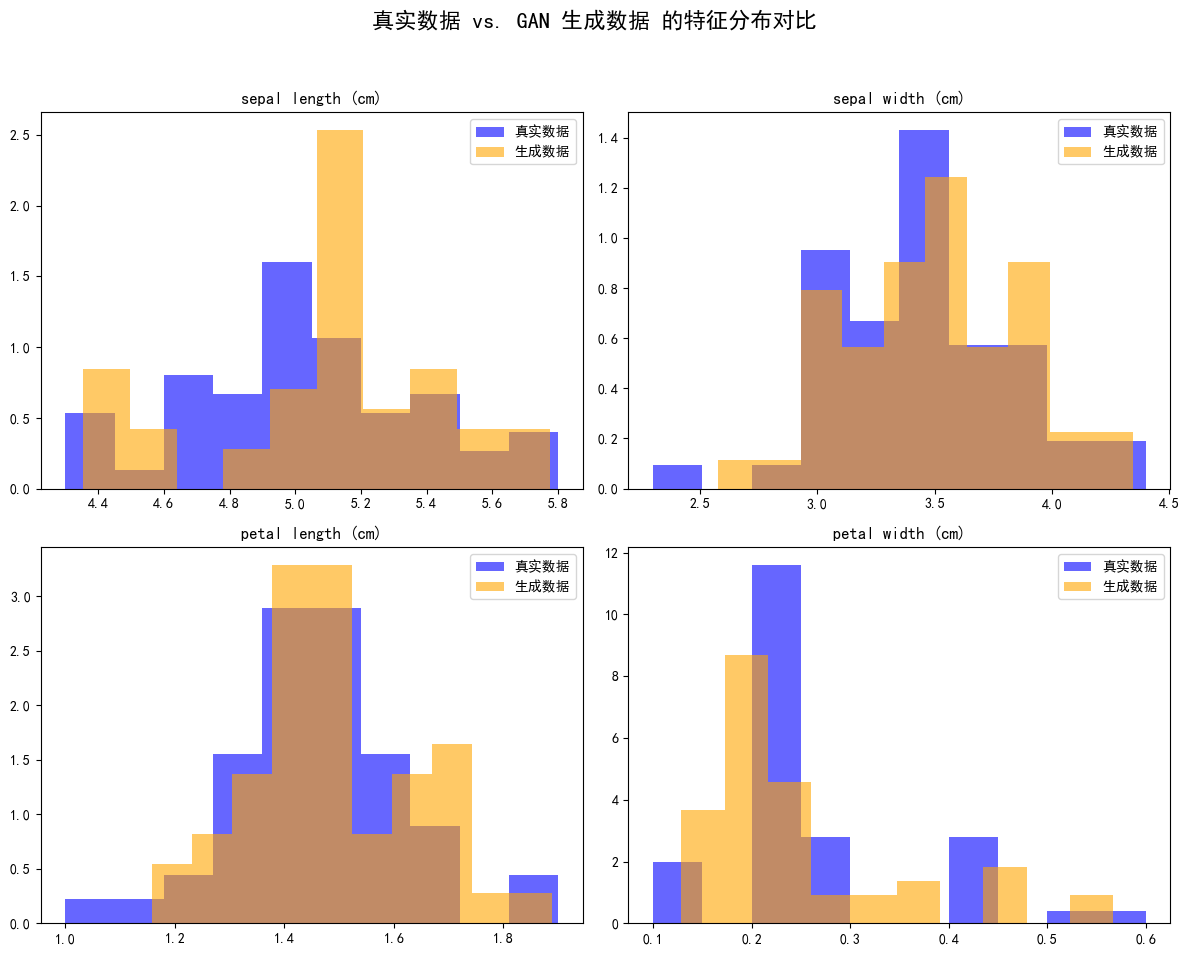

In [10]:
# =====================================
# 11. 绘制分布对比图
# =====================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('真实数据 vs. GAN 生成数据 的特征分布对比', fontsize=16)

feature_names = iris.feature_names

for i, ax in enumerate(axes.flatten()):
    # 绘制真实数据分布
    ax.hist(real_data_original_scale[:, i], bins=10, density=True, 
            alpha=0.6, label='真实数据', color='blue')
    # 绘制生成数据分布
    ax.hist(generated_data[:, i], bins=10, density=True, 
            alpha=0.6, label='生成数据', color='orange')
    ax.set_title(feature_names[i])
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
# =====================================
# 12. 样本对比
# =====================================

print("\n" + "=" * 50)
print("真实样本 vs 生成样本 对比")
print("=" * 50)

print("\n前 5 个真实样本 (Setosa):")
print(pd.DataFrame(real_data_original_scale[:5], columns=feature_names))

print("\nGAN 生成的 5 个新样本:")
print(pd.DataFrame(generated_data[:5], columns=feature_names))


真实样本 vs 生成样本 对比

前 5 个真实样本 (Setosa):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

GAN 生成的 5 个新样本:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           5.148759          4.127601           1.596385          0.161868
1           4.596968          3.149535           1.310992          0.179905
2           5.149263          3.631080           1.801399          0.440728
3           5.153830          3.419333           1.452809          0.202663
4           5.295847          3.563348           1.374197          0.240964


---

## 八、总结与评估

### 8.1 如何评估 GAN 的效果？

GAN 训练效果的关键指标是**生成数据分布与真实数据分布的重合度**：

| 分布情况 | 说明 |
| --- | --- |
| 高度重叠 | 生成数据质量高，GAN 学习效果好 |
| 差异大、峰谷错位明显 | 生成数据存在偏差，GAN 学习不充分 |

### 8.2 定量评估指标

对于图像数据，常用的定量指标包括：

- **FID (Frechet Inception Distance)**：值越小越好
- **IS (Inception Score)**：值越大越好
- **KL 散度**：衡量两个分布的差异

### 8.3 本节要点回顾

1. **GAN 核心思想**：生成器和判别器的对抗博弈
2. **训练流程**：交替训练判别器和生成器
3. **关键技术**：
   - nn.Sequential 容器简化网络定义
   - LeakyReLU 避免神经元死亡
   - .detach() 阻止梯度回传
4. **应用场景**：数据增强、少数类样本生成